## PyMC GeoMod Sandstone Simplified: Adding gravimetry inversion

#### Importing stuff

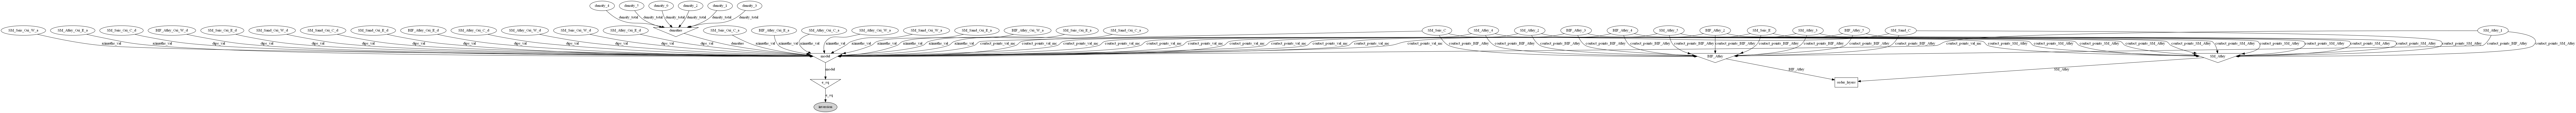

In [13]:
Image("Sandstone_grav_Inv_densities.png")

In [1]:
%matplotlib inline
from IPython.core.display import Image
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import shutil
#import geobayes_simple as gs
from itertools import chain
import pymc as pm # PyMC 2
from pymc.Matplot import plot
from pymc import graph as gr
import pandas as pn
import numpy as np
#import daft
from IPython.core.pylabtools import figsize
figsize(12.5, 10)
# as we have our model and pygeomod in different paths, let's change the pygeomod path to the default path.
sys.path.append("C:\Users\Miguel\workspace\pygeomod\pygeomod")
#sys.path.append(r'/home/jni/git/tmp/pygeomod_tmp')
import geogrid
import geomodeller_xml_obj as gxml
reload(gxml)
reload(geogrid)



Couldn't import dot_parser, loading of dot files will not be possible.


<module 'geogrid' from 'C:\Users\Miguel\workspace\pygeomod\pygeomod\geogrid.pyc'>

In [2]:
sandstone0 = r'..\Geomodeller\Sandstone_small\Sandstone_small.xml'
sandstone2 = r'..\Geomodeller\Sandstone_extremely_simpified\Sandstone_extremely_simpified.xml'
sandstone3 = r'..\Geomodeller\Sandstone_ASEG\Sandstone_ASEG.xml'
sandstone4 = r'C:\Users\Miguel\workspace\geobayes\paper_sandstone\models\Sandstone_Ruth.xml'
sandstone = r'C:\Users\Miguel\workspace\geobayes\paper_sandstone\models\SanstoneSimple\SanstoneSimple.xml'

In [3]:
try:
    shutil.copytree(r'C:/Users/Miguel/workspace/geobayes/paper_sandstone/models/SanstoneSimple/', 'Temp_Sandstone/')
except WindowsError:
    print "The folder is already created"

The folder is already created


### Creating the Bayesian Model of the input data!
#### First: Importing the uncertainty data from geolgical observations


In [2]:
data = pn.read_excel("C:\Users\Miguel\workspace\geobayes\paper_sandstone\models\Uncertainties.xlsx")                    
data_ar = data.values[:,[0,3,6,7]]
#print np.asarray(data_ar[data_ar[:,1] == "depth"][:,[0,2,3]])


#### Second: Importing Geophysic data

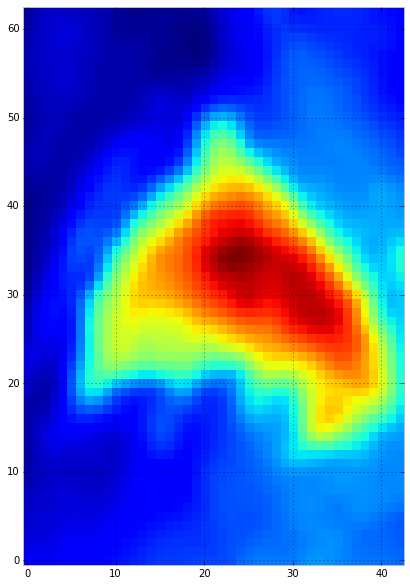

In [3]:
Sst_grav_1000 = np.loadtxt('Temp_Sandstone\Sandstone_geophys\Sst_grav_1000.xyz')
Sst_grav_2000 = np.loadtxt('Temp_Sandstone\Sandstone_geophys\Sst_grav_2000.xyz')
Sst_grav_500 = np.loadtxt('Temp_Sandstone\Sandstone_geophys\Sst_grav_500.xyz')
# Extracting information:
Grav_1000 = Sst_grav_1000[:,3].reshape((63,43))
# Normalizing
Grav_1000_norm = (Grav_1000-np.max(Grav_1000))/np.min(Grav_1000-np.max(Grav_1000))

plt.imshow(Grav_1000_norm, origin = "lower left",
       interpolation = 'nearest', cmap = 'jet_r')

## Creating out PyMC model our of this


In the first try we are gonna take the surface points as real values since in any case they will have less uncertainty.

In [12]:
#==============================
# Stochastics: Our input data
#============================
data_depth = np.asarray(data_ar[data_ar[:,1] == "depth"][:,[0, 2,3]])
contact_points_mc = []
for i in range(len(data_depth)):
    contact_points_mc = np.append(contact_points_mc, pm.Normal(str(data_depth[i,0]), data_depth[i,1], 1./np.square(data_depth[i,2])))

data_azimuth = np.asarray(data_ar[data_ar[:,1] == "azimuth"][:,[0, 2,3]])
azimuths_mc = []    
for i in range(len(data_azimuth)):
    azimuths_mc = np.append(azimuths_mc, pm.Normal(str(data_azimuth[i,0]), data_azimuth[i,1], 1./np.square(data_azimuth[i,2])))   

data_dip = np.asarray(data_ar[data_ar[:,1] == "dip"][:,[0, 2,3]])
dips_mc = []
for i in range(len(data_dip)):
    dips_mc = np.append(dips_mc, pm.Normal(str(data_dip[i,0]), data_dip[i,1], 1./np.square(data_dip[i,2])))  

density_0 = pm.Normal("density_0", 0.1, 1./np.square(0.01))
density_1 = pm.Normal("density_1", 2610., 1./np.square(20))
density_2 = pm.Normal("density_2", 2920., 1./np.square(20))
density_3 = pm.Normal("density_3", 3100., 1./np.square(20))
density_4 = pm.Normal("density_4", 2920., 1./np.square(20))
density_5 = pm.Normal("density_5", 2610., 1./np.square(20))

density_total = [density_0, density_1, density_2, density_3, density_4, density_5]
@pm.deterministic
def densities(density_total = density_total):
    density = {}
    for i, den in enumerate(density_total):
        density[i] = float(den)
   # print density
    return density
#===============================
# First Constrains: Input data
#=============================
@pm.deterministic
def SM_Atley(contact_points_SM_Atley = contact_points_mc):
    SM_Atley = contact_points_mc[[int(np.argwhere(data_depth[:,0]=="SM_Atley_2")),int(np.argwhere(data_depth[:,0]=="SM_Atley_3")),
                              int(np.argwhere(data_depth[:,0]=="SM_Atley_4")),int(np.argwhere(data_depth[:,0]=="SM_Atley_5"))]]
    return SM_Atley
@pm.deterministic
def BIF_Atley(contact_points_BIF_Atley = contact_points_mc):
    BIF_Atley = contact_points_mc[[int(np.argwhere(data_depth[:,0]=="BIF_Atley_2")),int(np.argwhere(data_depth[:,0]=="BIF_Atley_3")),
                                  int(np.argwhere(data_depth[:,0]=="BIF_Atley_4")),int(np.argwhere(data_depth[:,0]=="BIF_Atley_5"))]]
    return BIF_Atley


@pm.potential
def order_layers(SM_Atley = SM_Atley, BIF_Atley = BIF_Atley):
    Atley_dif_1 = SM_Atley - BIF_Atley
    if np.amin(Atley_dif_1) < 400:
        return -1
    if np.amin(Atley_dif_1) < 0:
        try:
            counter_OL += 1      
        except UnboundLocalError:
            counter_OL = 0
        return -2
    return 0
   
# ===============================================================================
# Generation of model
# ===============================================================================
@pm.deterministic
def model(contact_points_val_mc = contact_points_mc, azimuths_val = azimuths_mc , dips_val = dips_mc, densities = densities):
# IMPORTANT NOTE: To be sure that the point we want to change fit with the Observation ID, I use the distribution name that
# in this case is in contact_points(parent values). Children values (contact_points_val) only have the number itself
    
    #print "contact_points_mc", contact_points_mc, contact_points_mc[0].value
    #print "caontact points val_mc", contact_points_val_mc[0]
   
  
    # Create the array we will use to modify the xml. We have to check the order of the formations
    
    
        #==================================================
        # Loading old model
        #==============================================
    # Load the xml to be modify
    org_xml = 'Temp_Sandstone/SanstoneSimple.xml'
    
    #Create the instance to modify the xml
        # Loading stuff
    reload(gxml) 
    gmod_obj = gxml.GeomodellerClass()
    gmod_obj.load_geomodeller_file(org_xml)

    
        #============================================
        # Modifing the model
        #===========================================
    gmod_obj.change_formation_values_PyMC(contact_points_mc = contact_points_mc,
                                         azimuths_mc = azimuths_mc,
                                         dips_mc = dips_mc)
    
 
    
        #==============================================
        # wtiting new model
        #============================================

    # Write the new xml
    gmod_obj.write_xml("Temp_Sandstone/new.xml")
       
    # Read the new xml
    new_xml = 'Temp_Sandstone/new.xml'
    G1 = geogrid.GeoGrid()
    
    # Getting dimensions and definning grid
    G1.get_dimensions_from_geomodeller_xml_project(new_xml)
    G1.set_dimensions(dim=(705000,747000,6863000,6925000,-9272,1000))
    
    
    # Resolution!
    nx = 43
    ny = 63
    nz = 40
    G1.define_regular_grid(nx,ny,nz)
    
    # Updating project
    G1.update_from_geomodeller_project(new_xml)
    
    # Geophysics
    #print densities
    G1.analyse_geophysics(densities)
    
    return G1


#================================
# Second Constrains: Interpolation
#===============================




#=================================
# Inversion
#=================================

@pm.deterministic
def e_sq(value = Grav_1000_norm,model = model):
    Forw = model.geophys.grv_data
    Forw_norm = (Forw-np.max(Forw))/np.min(Forw-np.max(Forw))
    e_sq = np.square(np.sum(value - Forw_norm))
    print e_sq
    return e_sq


@pm.stochastic(observed = True)
def inversion(value = Grav_1000_norm, e_sq = e_sq):
    

    # 200000 is the tuned value

    
  #  Forw = model.geophys.grv_data
   # Forw_norm = (Forw-np.max(Forw))/np.min(Forw-np.max(Forw))
    #e_sq = np.square(np.sum(value - Forw_norm))    
    # print e_sq, (pm.half_cauchy_like(e_sq/200000,0.8,2.5)-pm.half_cauchy_like(0.8,0.8,2.5)), \
    #  10**(pm.half_cauchy_like(e_sq/200000,0.8,2.5)-pm.half_cauchy_like(0.8,0.8,2.5))
    return (pm.half_cauchy_like(i/10000,0.8,60)-pm.half_cauchy_like(0.8,0.8,60))
   # return (pm.half_cauchy_like(e_sq/200000,0.8,2.5)-pm.half_cauchy_like(0.8,0.8,2.5))
   

#===========================================================
#===========================================================
#CREATING THE MODEL
#==========================================================
#=========================================================

# Chaining the arrays
parameters = list(chain(contact_points_mc,dips_mc,azimuths_mc))

# Appending the rest
parameters.append(model)
parameters.append(BIF_Atley)
parameters.append(SM_Atley)
parameters.append(order_layers)

parameters.append(e_sq)
parameters.append(inversion)


pymc_model = pm.Model( parameters)

540667.156791


In [12]:
a = gr.dag(pymc_model)
a.write_png("Sandstone_grav_Inv_densities.png")

True

In [13]:
S = pm.MCMC(pymc_model,  db= "hdf5" , dbname= "database_sands_beta/Sandstone_inv_densities.hdf5")
#S.restore_sampler_state()

In [14]:
#chain 1
S.sample(iter = 5)

516432.931272
328012.527297
67279.8379856
132913.014168
328012.527297
328009.422898
328062.766457
327916.664897
329138.294276
1793178.83405
327617.906686
151152.186496
151152.186496
151152.186496
492883.68976
151152.186496
151142.758083
385017.045398
151142.758083
151142.758083
151142.758083
151142.758083
151217.364605
151013.848061
647625.419087
280462.543013
136555.166722
136559.587795
330490.341638
114393.947521
121719.895028
136122.073816
136555.166722
391207.263802
136558.481843
116151.926376
152979.180063
136558.481843
136558.481843
155994.881402
136558.481843
 [---------------  40%                  ] 2 of 5 complete in 805.0 sec328675.296042
384929.626319
1764532.10968
541190.523738
136558.481843
136535.688743
152674.438993
131389.324292
136728.950849
75400.5750041
136564.199018
329309.395297
329595.839139
329309.395297
135429.615387
329309.395297
329462.290063
514559.691931
176176.834195
329309.395297
329309.395297
329309.395297
329437.42463
329368.137838
1112.00827049
111340.0

C:\Users\Miguel\Anaconda\lib\site-packages\pymc\database\hdf5.py:485: UserWarning: 
Error tallying SM_Atley, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (most recent call last):
  File "C:\Users\Miguel\Anaconda\lib\site-packages\pymc\database\hdf5.py", line 475, in tally
    self._traces[name].tally(chain)
  File "C:\Users\Miguel\Anaconda\lib\site-packages\pymc\database\hdf5.py", line 64, in tally
    self._vlarrays[chain].append(self._getfunc())
  File "C:\Users\Miguel\Anaconda\lib\site-packages\tables\vlarray.py", line 518, in append
    sequence = atom.toarray(sequence)
  File "C:\Users\Miguel\Anaconda\lib\site-packages\tables\atom.py", line 1040, in toarray
    buffer_ = self._tobuffer(object_)
  File "C:\Users\Miguel\Anaconda\lib\site-packages\tables\atom.py", line 1160, in _tobuffer
    return cPickle.dumps(object_, cPickle.HIGHEST_PROTOCOL)
Pick

In [7]:
#new
S.sample(iter = 5)

352986.682016
346750.233451
357968.638722
356978.830883
352986.682016
348760.637808
337744.155593
360517.330275
337744.155593
431483.138934
412694.489102
338243.376613
341582.711451
598205.228234
614899.727326
338130.008475
338243.376613
334835.699142
337574.385168
243489.256119
366750.152502
366750.152502
353800.058727
370945.697216
373041.062863
370945.697216
385598.275545
347818.451491
363008.970435
435152.042117
376971.968468
370945.697216
369242.057708
400119.313742
 [---------------  40%                  ] 2 of 5 complete in 578.9 sec372294.177979
378567.066543
399580.05535
383504.331482
399580.05535
389723.624773
393348.503411
392858.700487
319184.366817
399580.05535
418965.872885
393490.872154
399580.05535
637634.875016
607552.283348
399580.05535
399580.05535
399616.329802
399488.681572
399616.329802
364180.0303
399616.329802
391493.560561
391275.554237
391275.554237
391275.554237
371591.038461
377895.889269
399316.455466
269249.845382
407870.135241
391275.554237
350675.767784


C:\Users\Miguel\Anaconda\lib\site-packages\pymc\database\hdf5.py:485: UserWarning: 
Error tallying SM_Atley, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (most recent call last):
  File "C:\Users\Miguel\Anaconda\lib\site-packages\pymc\database\hdf5.py", line 475, in tally
    self._traces[name].tally(chain)
  File "C:\Users\Miguel\Anaconda\lib\site-packages\pymc\database\hdf5.py", line 64, in tally
    self._vlarrays[chain].append(self._getfunc())
IndexError: list index out of range

  %s""" % (name, ''.join(traceback.format_exception(cls, inst, tb))))
C:\Users\Miguel\Anaconda\lib\site-packages\pymc\database\hdf5.py:485: UserWarning: 
Error tallying BIF_Atley, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (most recent cal

In [12]:
#old
for i in range(5):
    print i
    S.sample(iter=8)
    S.db.commit()
    S.restore_sampler_state()

0
285877.00557
273418.287481
285877.00557
525673.41027
225150.807189
225150.807189
225150.807189
235583.706484
225150.807189
226507.164909
246832.339071
188272.749777
223717.644097
225150.807189
237270.164512
221960.489327
222509.553531
262933.785719
233702.490688
236525.848893
233702.490688
248377.644098
275145.76691
237887.409918
276226.229378
233702.490688
287399.733645
245763.696799
287477.906661
238557.045002
233702.490688
227566.896822
180348.063793
180348.063793
 [---------        25%                  ] 2 of 8 complete in 586.7 sec187048.355747
156785.781949
160037.650101
212596.68993
360647.616967
180348.063793
180348.063793
232794.041604
180348.063793
163748.317233
242766.428523
175214.760102
180348.063793
180348.063793
289905.272712
238798.763241
262269.546533
255618.659166
340215.113565
201186.065964
238798.763241
291164.92252
297929.095608
256819.8287
305119.749161
238798.763241
231530.483568
271442.951881
244136.205677
246792.258366
244136.205677
192356.140781
377398.28191

C:\Users\Miguel\Anaconda\lib\site-packages\pymc\database\hdf5.py:485: UserWarning: 
Error tallying SM_Atley, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (most recent call last):
  File "C:\Users\Miguel\Anaconda\lib\site-packages\pymc\database\hdf5.py", line 475, in tally
    self._traces[name].tally(chain)
  File "C:\Users\Miguel\Anaconda\lib\site-packages\pymc\database\hdf5.py", line 64, in tally
    self._vlarrays[chain].append(self._getfunc())
  File "C:\Users\Miguel\Anaconda\lib\site-packages\tables\vlarray.py", line 518, in append
    sequence = atom.toarray(sequence)
  File "C:\Users\Miguel\Anaconda\lib\site-packages\tables\atom.py", line 1040, in toarray
    buffer_ = self._tobuffer(object_)
  File "C:\Users\Miguel\Anaconda\lib\site-packages\tables\atom.py", line 1160, in _tobuffer
    return cPickle.dumps(object_, cPickle.HIGHEST_PROTOCOL)
Pick

KeyError: -2147483648L

In [37]:
S.restore_sampler_state()

In [39]:
S.get_state()

{'sampler': {'_burn': 0,
  '_burn_till_tuned': False,
  '_current_iter': 3,
  '_iter': 3,
  '_thin': 1,
  '_tune_interval': 1000,
  '_tune_throughout': True,
  '_tuned_count': 0,
  'status': 'ready'},
 'step_methods': {},
 'stochastics': {'BIF_Atley_2': array(1708.5288608583896),
  'BIF_Atley_3': array(3929.5231062126422),
  'BIF_Atley_4': array(626.8201636680639),
  'BIF_Atley_5': array(1817.840736925059),
  'BIF_Atley_Ori_E_a': array(206.683312934975),
  'BIF_Atley_Ori_E_d': array(47.53009617384745),
  'BIF_Atley_Ori_W_a': array(77.06939430403897),
  'BIF_Atley_Ori_W_d': array(63.81922770638265),
  'SM_Atley_1': array(4459.89464011109),
  'SM_Atley_2': array(3540.4371114674427),
  'SM_Atley_3': array(6008.299228277382),
  'SM_Atley_4': array(3161.1605960875554),
  'SM_Atley_5': array(5470.473283090355),
  'SM_Atley_Ori_C_a': array(-13.71676827415489),
  'SM_Atley_Ori_C_d': array(-3.881664993342094),
  'SM_Atley_Ori_E_a': array(261.2999609655013),
  'SM_Atley_Ori_E_d': array(53.857988

In [41]:
S.db.close?

In [34]:
%whos


Variable            Type             Data/Info
----------------------------------------------
BIF_Atley           Deterministic    BIF_Atley
Grav_1000           ndarray          63Lx43L: 2709 elems, type `float64`, 21672 bytes
Grav_1000_norm      ndarray          63Lx43L: 2709 elems, type `float64`, 21672 bytes
Image               type             <class 'IPython.core.display.Image'>
S                   MCMC             <pymc.MCMC.MCMC object at 0x000000002D188780>
SM_Atley            Deterministic    SM_Atley
Sst_grav_1000       ndarray          2709Lx4L: 10836 elems, type `float64`, 86688 bytes
Sst_grav_2000       ndarray          651Lx4L: 2604 elems, type `float64`, 20832 bytes
Sst_grav_500        ndarray          10625Lx4L: 42500 elems, type `float64`, 340000 bytes (332 kb)
a                   Dot              <pydot.Dot object at 0x000000003393E668>
azimuths_mc         ndarray          11L: 11 elems, type `object`, 88 bytes
chain               type             <type 'itertools.cha